<a href="https://colab.research.google.com/github/venkatesh1226/CMPE255-DataMining/blob/main/Clustering_scratch_customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Unzipping the uploaded file
zip_file_path_retail = '/content/drive/MyDrive/DM_Assignment_06/OnlineRetail.csv.zip'
extraction_path_retail = '/content/drive/MyDrive/DM_Assignment_06/OnlineRetail.csv'

# Unzipping the file
with zipfile.ZipFile(zip_file_path_retail, 'r') as zip_ref:
    zip_ref.extractall(extraction_path_retail)

# Listing the contents of the extracted folder
extracted_files_retail = os.listdir(extraction_path_retail)
extracted_files_retail


['OnlineRetail.csv']

Exploring Dataset

In [9]:
import pandas as pd

# Load the dataset with the correct encoding
df_retail = pd.read_csv('/content/drive/MyDrive/DM_Assignment_06/OnlineRetail.csv/OnlineRetail.csv', encoding='ISO-8859-1')

# Display the first few rows
print(df_retail.head())

# Display summary statistics
print(df_retail.describe())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.6003

In [10]:
# Check for missing values
print(df_retail.isnull().sum())


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


Step 1: Preprocessing for RFM Analysis

You'll need to create features for Recency, Frequency, and Monetary values.

In [11]:
import pandas as pd
from datetime import datetime

# Convert InvoiceDate to datetime and drop NA values
df_retail['InvoiceDate'] = pd.to_datetime(df_retail['InvoiceDate'])
df_retail.dropna(subset=['CustomerID'], inplace=True)

# Monetary
df_retail['TotalPrice'] = df_retail['Quantity'] * df_retail['UnitPrice']

# Assuming the latest date in your dataset is the current date
current_date = df_retail['InvoiceDate'].max()

# RFM Analysis
rfm = df_retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency',
                   'InvoiceNo': 'Frequency',
                   'TotalPrice': 'Monetary'})

# Reset index
rfm.reset_index(inplace=True)


Step 2: Data Normalization

Before applying K-Means, you should normalize the RFM values.

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


Step 3: K-Means Clustering

Now, you can apply K-Means clustering. You'll need to decide on the number of clusters (k).

In [21]:
from sklearn.cluster import KMeans

# Choose the number of clusters (k)
k = 2

# Apply K-Means
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(rfm_scaled)

# Add the cluster data to the RFM dataframe
rfm['Cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Step 4: Analyzing the Results

After clustering, you can analyze the characteristics of each cluster.

In [22]:
# Average values for each cluster
cluster_avg = rfm.groupby('Cluster').mean()

# Count of customers in each cluster
cluster_counts = rfm['Cluster'].value_counts()

print(cluster_avg)
print(cluster_counts)


           CustomerID     Recency   Frequency       Monetary       PCA1  \
Cluster                                                                   
0        15300.119578  101.266927    4.742254    1549.929342  -0.052108   
1        15171.333333    8.266667  101.866667  103134.911333  15.135620   

             PCA2  
Cluster            
0       -0.018871  
1        5.481339  
0    4357
1      15
Name: Cluster, dtype: int64


To visualise it we need to reduce the dimension

Step 1: Dimensionality Reduction using PCA

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Applying PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Adding PCA results to the RFM dataframe
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]


Step 2: Plotting the clusters

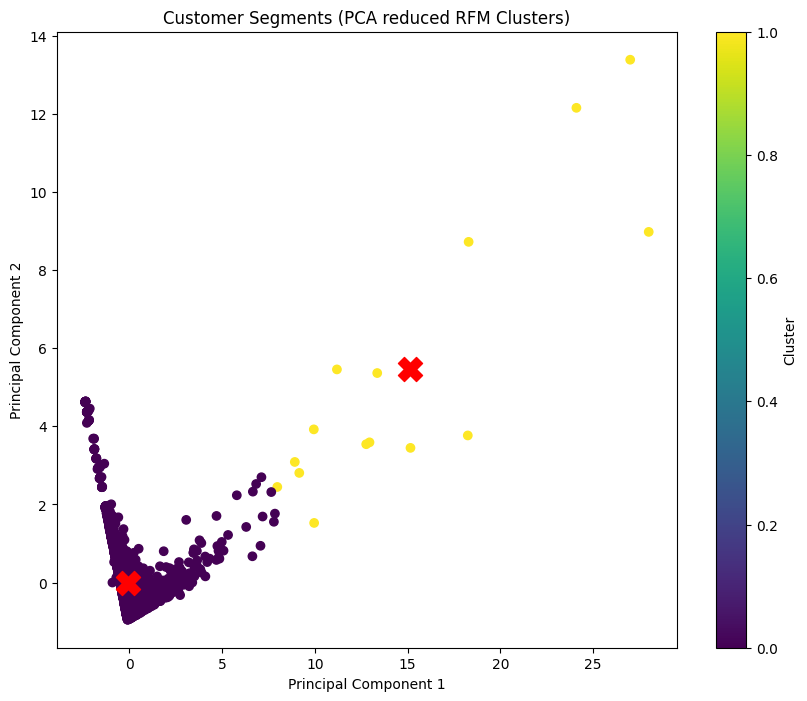

In [24]:
# Scatter plot of the clusters
plt.figure(figsize=(10, 8))
plt.scatter(rfm['PCA1'], rfm['PCA2'], c=rfm['Cluster'], cmap='viridis', label=rfm['Cluster'])
plt.title('Customer Segments (PCA reduced RFM Clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

# Optionally, label the cluster centers
cluster_centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=300, c='red', label='Centers', marker='X')

plt.show()
